In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

df_all = pd.read_csv("features_63_label_2.csv", header=0, encoding="utf-8").drop(["Unnamed: 0"], axis=1)
df_user_id = df_all["user_id"]
df_label = df_all["award_id"].factorize()[0]
df_all.drop(["user_id", "award_id"], axis=1, inplace=True)
dense_mapping = {
    "专业选修课成绩": "po_grade",
    "专业选修课学分": "po_credit",
    "专业必修课成绩": "pm_grade",
    "专业必修课学分": "pm_credit",
    "选修课成绩": "op_grade",
    "选修课学分": "op_credit",
    "公共必修课成绩": "cm_grade",
    "公共必修课学分": "cm_credit",
    "未分类课成绩": "uc_grade",
    "未分类课学分": "uc_credit",
    "总成绩": "tl_grade", 
    "总学分": "tl_credit",
}
df_all.rename(columns=dense_mapping, inplace=True)
col = list(df_all.columns)
sparse_features = col[: -12]
sparse_features

['paper_count',
 'paper_authOrder_0',
 'paper_conferenceChoice_0',
 'paper_paperState_0',
 'paper_labels_0',
 'paper_authOrder_1',
 'paper_conferenceChoice_1',
 'paper_paperState_1',
 'paper_labels_1',
 'paper_authOrder_2',
 'paper_conferenceChoice_2',
 'paper_paperState_2',
 'paper_labels_2',
 'patent_record_count',
 'patent_record_classify_0',
 'patent_record_classify_1',
 'patent_record_classify_2',
 'research_award_count',
 'research_award_competeRange_0',
 'research_award_awardLevel_0',
 'research_award_labels_0',
 'research_award_competeRange_1',
 'research_award_awardLevel_1',
 'research_award_labels_1',
 'research_award_competeRange_2',
 'research_award_awardLevel_2',
 'research_award_labels_2',
 'research_project_count',
 'research_project_projectType_0',
 'research_project_projectType_1',
 'research_project_projectType_2',
 'competition_award_count',
 'competition_award_competeRange_0',
 'competition_award_awardLevel_0',
 'competition_award_labels_0',
 'competition_award_comp

In [6]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

num_round = 1000

data = df_all.copy()

## category feature one_hot
cate_feature = sparse_features
for item in cate_feature:
    if "count" in item:
        cate_feature.remove(item)
        continue
    data[item] = LabelEncoder().fit_transform(data[item])
    item_dummies = pd.get_dummies(data[item])
    item_dummies.columns = [item + str(i + 1) for i in range(item_dummies.shape[1])]
    data = pd.concat([data, item_dummies], axis=1)
data.drop(cate_feature,axis=1,inplace=True)

In [8]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
# from xgboost.sklearn import XGBClassifier
import gc
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, mean_squared_error, zero_one_loss

In [12]:
import random

# train_x, test_x, train_y, test_y = train_test_split(data, data_y, test_size=0.1, random_state=100)

train_x, test_x, train_y, test_y = train_test_split(data, df_label, test_size=0.2, random_state=random.randint(1, 200))

In [13]:
dtrain = xgb.DMatrix(data=train_x, label=train_y, missing=-999.0)
dtest = xgb.DMatrix(data=test_x, label=test_y, missing=-999.0)

In [16]:
import hyperopt
from hyperopt import fmin, tpe, hp, partial, STATUS_OK, Trials

def hyperopt_objective(params):
    
    model = xgb.XGBClassifier(n_estimators = params['n_estimators'],
                            max_depth = int(params['max_depth']),
                            learning_rate = params['learning_rate'],
                            gamma = params['gamma'],
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            colsample_bytree = params['colsample_bytree'],
                            num_class=2,
                            objective="multi:softmax",
                            # eval_metric="auc",
                            # auc doesn't work with multi-classification https://github.com/dmlc/xgboost/issues/1208
                            eval_metric="mlogloss",
                            seed=31415926,
                            nthread=-1,
                            silent=1
                            )
     
    res = xgb.cv(model.get_params(), dtrain, num_boost_round=30, nfold=5,
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                        xgb.callback.early_stop(5)])
    
    # return np.min(res['test-mlogloss-mean']) # as hyperopt minimises
    return np.min(res['test-mlogloss-mean'])

In [17]:
params_space = {
    'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 1.0, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'booster': 'gbtree',
    'tree_method': 'exact',
    'silent': 1,
}

In [18]:
from numpy.random import RandomState

trials = hyperopt.Trials()

best = fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=RandomState(123)
)

print("\n展示hyperopt获取的最佳结果，但是要注意的是我们对hyperopt最初的取值范围做过一次转换")
print(best)

[0]	train-mlogloss:0.642293	test-mlogloss:0.647345     

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.

[1]	train-mlogloss:0.603955	test-mlogloss:0.615632     

[2]	train-mlogloss:0.567479	test-mlogloss:0.596924     

[3]	train-mlogloss:0.543796	test-mlogloss:0.579651     

[4]	train-mlogloss:0.515597	test-mlogloss:0.562931     

[5]	train-mlogloss:0.495439	test-mlogloss:0.551522     

[6]	train-mlogloss:0.478448	test-mlogloss:0.539741     

[7]	train-mlogloss:0.463786	test-mlogloss:0.529741     

[8]	train-mlogloss:0.449032	test-mlogloss:0.524667     

[9]	train-mlogloss:0.437235	test-mlogloss:0.520202     

[10]	train-mlogloss:0.424875	test-mlogloss:0.513719    

[11]	train-mlogloss:0.415311	test-mlogloss:0.507612    

[12]	train-mlogloss:0.404244	test-mlogloss:0.506217    

[13]	train-mlogloss:0.388959	test-mlogloss:0.504638    

[14]	train-mlogloss:0.383457	test-mlogloss:0.50550

Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.670039	test-mlogloss:0.67238                       

[2]	train-mlogloss:0.660624	test-mlogloss:0.664389                      

[3]	train-mlogloss:0.652366	test-mlogloss:0.657246                      

[4]	train-mlogloss:0.645034	test-mlogloss:0.650467                      

[5]	train-mlogloss:0.637332	test-mlogloss:0.643737                      

[6]	train-mlogloss:0.629769	test-mlogloss:0.637207                      

[7]	train-mlogloss:0.623234	test-mlogloss:0.632004                      

[8]	train-mlogloss:0.617215	test-mlogloss:0.626623                      

[9]	train-mlogloss:0.611204	test-mlogloss:0.622239                      

[10]	train-mlogloss:0.605806	test-mlogloss:0.617798                     

[11]	train-mlogloss:0.600983	test-mlogloss:0.614464                     

[12]	train-mlogloss:0.596416	test-mlogloss:0.612325                     

[13]	train-mlogloss:0.591915	test-mlog

[25]	train-mlogloss:0.561195	test-mlogloss:0.579856                     

[26]	train-mlogloss:0.560008	test-mlogloss:0.578951                     

[27]	train-mlogloss:0.558182	test-mlogloss:0.578405                     

[28]	train-mlogloss:0.556701	test-mlogloss:0.578726                     

[29]	train-mlogloss:0.555691	test-mlogloss:0.578166                     

[0]	train-mlogloss:0.522294	test-mlogloss:0.577402                      

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.434373	test-mlogloss:0.52838                       

[2]	train-mlogloss:0.363192	test-mlogloss:0.505105                      

[3]	train-mlogloss:0.318496	test-mlogloss:0.49307                       

[4]	train-mlogloss:0.282701	test-mlogloss:0.465768                      

[5]	train-mlogloss:0.256853	test-mlogloss:0.45541                       

[6]	train-mlogloss:0.

[13]	train-mlogloss:0.507821	test-mlogloss:0.578097                                

[14]	train-mlogloss:0.503473	test-mlogloss:0.575765                                

[15]	train-mlogloss:0.496849	test-mlogloss:0.587448                                

[16]	train-mlogloss:0.494696	test-mlogloss:0.59319                                 

[17]	train-mlogloss:0.488568	test-mlogloss:0.590062                                

[18]	train-mlogloss:0.487479	test-mlogloss:0.590834                                

[19]	train-mlogloss:0.481999	test-mlogloss:0.579674                                

Stopping. Best iteration:                                                          
[14]	train-mlogloss:0.503473+0.0294111	test-mlogloss:0.575765+0.0583652


[0]	train-mlogloss:0.646218	test-mlogloss:0.644812                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.            

[12]	train-mlogloss:0.258527	test-mlogloss:0.493093                                

Stopping. Best iteration:                                                          
[7]	train-mlogloss:0.335857+0.0172252	test-mlogloss:0.477116+0.0780589


[0]	train-mlogloss:0.653435	test-mlogloss:0.662627                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.622423	test-mlogloss:0.637987                                 

[2]	train-mlogloss:0.591745	test-mlogloss:0.618882                                 

[3]	train-mlogloss:0.566163	test-mlogloss:0.602228                                 

[4]	train-mlogloss:0.542754	test-mlogloss:0.588125                                 

[5]	train-mlogloss:0.522791	test-mlogloss:0.575799                                 

[6]	train-mlogloss:0.503064	test-mlogloss:0.566101                      

[6]	train-mlogloss:0.342106	test-mlogloss:0.500505                                 

[7]	train-mlogloss:0.325971	test-mlogloss:0.500052                                 

[8]	train-mlogloss:0.31055	test-mlogloss:0.493621                                  

[9]	train-mlogloss:0.301151	test-mlogloss:0.499917                                 

Stopping. Best iteration:                                                          
[4]	train-mlogloss:0.384051+0.0178878	test-mlogloss:0.493619+0.0824052


[0]	train-mlogloss:0.51242	test-mlogloss:0.57963                                   

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.429038	test-mlogloss:0.510564                                 

[2]	train-mlogloss:0.359706	test-mlogloss:0.470574                                 

[3]	train-mlogloss:0.318583	test-mlogloss:0.461061                      

[3]	train-mlogloss:0.414709	test-mlogloss:0.503918                                 

[4]	train-mlogloss:0.383902	test-mlogloss:0.498596                                 

[5]	train-mlogloss:0.358459	test-mlogloss:0.49828                                  

[6]	train-mlogloss:0.33848	test-mlogloss:0.49263                                   

[7]	train-mlogloss:0.323728	test-mlogloss:0.488298                                 

[8]	train-mlogloss:0.317526	test-mlogloss:0.485426                                 

[9]	train-mlogloss:0.307854	test-mlogloss:0.484427                                 

[10]	train-mlogloss:0.295252	test-mlogloss:0.49291                                 

[11]	train-mlogloss:0.290085	test-mlogloss:0.498733                                

[12]	train-mlogloss:0.285506	test-mlogloss:0.501115                                

[13]	train-mlogloss:0.280612	test-mlogloss:0.502497                                

[14]	train-mlogloss:0.276773	test-mlogloss:0.500597              

[0]	train-mlogloss:0.532888	test-mlogloss:0.592082                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.450703	test-mlogloss:0.5332                                   

[2]	train-mlogloss:0.383654	test-mlogloss:0.490675                                 

[3]	train-mlogloss:0.34743	test-mlogloss:0.477862                                  

[4]	train-mlogloss:0.309147	test-mlogloss:0.462541                                 

[5]	train-mlogloss:0.289926	test-mlogloss:0.455615                                 

[6]	train-mlogloss:0.270761	test-mlogloss:0.45009                                  

[7]	train-mlogloss:0.262862	test-mlogloss:0.465282                                 

[8]	train-mlogloss:0.255417	test-mlogloss:0.46064                                  

[9]	train-mlogloss:0.246956	test-mlogloss:0.458168         

[2]	train-mlogloss:0.532837	test-mlogloss:0.583938                                 

[3]	train-mlogloss:0.49779	test-mlogloss:0.569117                                  

[4]	train-mlogloss:0.474239	test-mlogloss:0.554317                                 

[5]	train-mlogloss:0.4537	test-mlogloss:0.545365                                   

[6]	train-mlogloss:0.432994	test-mlogloss:0.537443                                 

[7]	train-mlogloss:0.415754	test-mlogloss:0.529789                                 

[8]	train-mlogloss:0.404104	test-mlogloss:0.521839                                 

[9]	train-mlogloss:0.391347	test-mlogloss:0.520869                                 

[10]	train-mlogloss:0.380995	test-mlogloss:0.519706                                

[11]	train-mlogloss:0.372049	test-mlogloss:0.521544                                

[12]	train-mlogloss:0.365401	test-mlogloss:0.52233                                 

[13]	train-mlogloss:0.355555	test-mlogloss:0.528396              

[5]	train-mlogloss:0.508781	test-mlogloss:0.581678                                 

[6]	train-mlogloss:0.497679	test-mlogloss:0.575165                                 

[7]	train-mlogloss:0.490492	test-mlogloss:0.575958                                 

[8]	train-mlogloss:0.482641	test-mlogloss:0.574314                                 

[9]	train-mlogloss:0.476719	test-mlogloss:0.570306                                 

[10]	train-mlogloss:0.468428	test-mlogloss:0.573302                                

[11]	train-mlogloss:0.464677	test-mlogloss:0.574561                                

[12]	train-mlogloss:0.45792	test-mlogloss:0.582447                                 

[13]	train-mlogloss:0.450399	test-mlogloss:0.582737                                

[14]	train-mlogloss:0.447269	test-mlogloss:0.587154                                

Stopping. Best iteration:                                                          
[9]	train-mlogloss:0.476719+0.0162331	test-mlogloss:0.570306+0.084

[3]	train-mlogloss:0.470877	test-mlogloss:0.558573                                 

[4]	train-mlogloss:0.438301	test-mlogloss:0.56074                                  

[5]	train-mlogloss:0.420918	test-mlogloss:0.569557                                 

[6]	train-mlogloss:0.404456	test-mlogloss:0.561226                                 

[7]	train-mlogloss:0.39581	test-mlogloss:0.559112                                  

[8]	train-mlogloss:0.389384	test-mlogloss:0.561961                                 

Stopping. Best iteration:                                                          
[3]	train-mlogloss:0.470877+0.0207422	test-mlogloss:0.558573+0.0876954


[0]	train-mlogloss:0.601555	test-mlogloss:0.613408                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.546584	test-mlogloss:0.569663                      

Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.617781	test-mlogloss:0.630368                                 

[2]	train-mlogloss:0.609111	test-mlogloss:0.621159                                 

[3]	train-mlogloss:0.60809	test-mlogloss:0.625218                                  

[4]	train-mlogloss:0.605982	test-mlogloss:0.614945                                 

[5]	train-mlogloss:0.604667	test-mlogloss:0.611737                                 

[6]	train-mlogloss:0.605591	test-mlogloss:0.611134                                 

[7]	train-mlogloss:0.606727	test-mlogloss:0.612048                                 

[8]	train-mlogloss:0.6073	test-mlogloss:0.612373                                   

[9]	train-mlogloss:0.603694	test-mlogloss:0.608097                                 

[10]	train-mlogloss:0.602211	test-mlogloss:0.614464                                

[11]	train-mlogloss:0.603755	test-mlogloss:0.62243               

[4]	train-mlogloss:0.45883	test-mlogloss:0.526547                                  

[5]	train-mlogloss:0.44298	test-mlogloss:0.518768                                  

[6]	train-mlogloss:0.427003	test-mlogloss:0.509829                                 

[7]	train-mlogloss:0.414286	test-mlogloss:0.50754                                  

[8]	train-mlogloss:0.406606	test-mlogloss:0.503501                                 

[9]	train-mlogloss:0.393745	test-mlogloss:0.495184                                 

[10]	train-mlogloss:0.378355	test-mlogloss:0.497329                                

[11]	train-mlogloss:0.363678	test-mlogloss:0.492066                                

[12]	train-mlogloss:0.352243	test-mlogloss:0.491089                                

[13]	train-mlogloss:0.340034	test-mlogloss:0.490737                                

[14]	train-mlogloss:0.335453	test-mlogloss:0.490646                                

[15]	train-mlogloss:0.328074	test-mlogloss:0.489118              

Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.494303	test-mlogloss:0.507087                                 

[2]	train-mlogloss:0.445875	test-mlogloss:0.497174                                 

[3]	train-mlogloss:0.410357	test-mlogloss:0.47805                                  

[4]	train-mlogloss:0.374242	test-mlogloss:0.471048                                 

[5]	train-mlogloss:0.351873	test-mlogloss:0.477463                                 

[6]	train-mlogloss:0.336088	test-mlogloss:0.464003                                 

[7]	train-mlogloss:0.321406	test-mlogloss:0.468572                                 

[8]	train-mlogloss:0.303236	test-mlogloss:0.477288                                 

[9]	train-mlogloss:0.289844	test-mlogloss:0.475653                                 

[10]	train-mlogloss:0.27342	test-mlogloss:0.479229                                 

[11]	train-mlogloss:0.265969	test-mlogloss:0.496077              

[6]	train-mlogloss:0.26635	test-mlogloss:0.436007                                  

[7]	train-mlogloss:0.261705	test-mlogloss:0.438359                                 

[8]	train-mlogloss:0.254187	test-mlogloss:0.437628                                 

[9]	train-mlogloss:0.248627	test-mlogloss:0.434795                                 

[10]	train-mlogloss:0.246414	test-mlogloss:0.438733                                

Stopping. Best iteration:                                                          
[5]	train-mlogloss:0.270171+0.0139714	test-mlogloss:0.434554+0.104097


[0]	train-mlogloss:0.551524	test-mlogloss:0.591155                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.471704	test-mlogloss:0.537606                                 

[2]	train-mlogloss:0.418577	test-mlogloss:0.513368                       

[12]	train-mlogloss:0.222921	test-mlogloss:0.462047                                

Stopping. Best iteration:                                                          
[7]	train-mlogloss:0.236249+0.0269756	test-mlogloss:0.457262+0.137205


[0]	train-mlogloss:0.509709	test-mlogloss:0.574789                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.414765	test-mlogloss:0.530815                                 

[2]	train-mlogloss:0.340407	test-mlogloss:0.498577                                 

[3]	train-mlogloss:0.303024	test-mlogloss:0.473332                                 

[4]	train-mlogloss:0.277368	test-mlogloss:0.451924                                 

[5]	train-mlogloss:0.259284	test-mlogloss:0.445245                                 

[6]	train-mlogloss:0.241976	test-mlogloss:0.4354                         

[3]	train-mlogloss:0.308765	test-mlogloss:0.471184                                 

[4]	train-mlogloss:0.273413	test-mlogloss:0.441112                                 

[5]	train-mlogloss:0.245505	test-mlogloss:0.445279                                 

[6]	train-mlogloss:0.224476	test-mlogloss:0.436305                                 

[7]	train-mlogloss:0.222954	test-mlogloss:0.436759                                 

[8]	train-mlogloss:0.218666	test-mlogloss:0.434737                                 

[9]	train-mlogloss:0.218607	test-mlogloss:0.434956                                 

[10]	train-mlogloss:0.211084	test-mlogloss:0.439039                                

[11]	train-mlogloss:0.209653	test-mlogloss:0.436298                                

[12]	train-mlogloss:0.207019	test-mlogloss:0.437224                                

[13]	train-mlogloss:0.20513	test-mlogloss:0.435664                                 

Stopping. Best iteration:                                        

[15]	train-mlogloss:0.39571	test-mlogloss:0.544962                                 

[16]	train-mlogloss:0.388671	test-mlogloss:0.541375                                

[17]	train-mlogloss:0.382787	test-mlogloss:0.536339                                

[18]	train-mlogloss:0.377918	test-mlogloss:0.542369                                

[19]	train-mlogloss:0.374524	test-mlogloss:0.540094                                

[20]	train-mlogloss:0.36745	test-mlogloss:0.536203                                 

[21]	train-mlogloss:0.363739	test-mlogloss:0.534421                                

[22]	train-mlogloss:0.362661	test-mlogloss:0.535024                                

[23]	train-mlogloss:0.360331	test-mlogloss:0.536525                                

[24]	train-mlogloss:0.356977	test-mlogloss:0.537327                                

[25]	train-mlogloss:0.353042	test-mlogloss:0.53076                                 

[26]	train-mlogloss:0.349865	test-mlogloss:0.531523              

[1]	train-mlogloss:0.403329	test-mlogloss:0.511599                                 

[2]	train-mlogloss:0.333944	test-mlogloss:0.480905                                 

[3]	train-mlogloss:0.285491	test-mlogloss:0.446087                                 

[4]	train-mlogloss:0.254321	test-mlogloss:0.43387                                  

[5]	train-mlogloss:0.227898	test-mlogloss:0.436105                                 

[6]	train-mlogloss:0.208643	test-mlogloss:0.441188                                 

[7]	train-mlogloss:0.197523	test-mlogloss:0.443971                                 

[8]	train-mlogloss:0.191208	test-mlogloss:0.445792                                 

[9]	train-mlogloss:0.186111	test-mlogloss:0.443715                                 

Stopping. Best iteration:                                                          
[4]	train-mlogloss:0.254321+0.024498	test-mlogloss:0.43387+0.101741


[0]	train-mlogloss:0.552284	test-mlogloss:0.618428                               

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.539651	test-mlogloss:0.570598                                 

[2]	train-mlogloss:0.509718	test-mlogloss:0.56999                                  

[3]	train-mlogloss:0.49037	test-mlogloss:0.570526                                  

[4]	train-mlogloss:0.469805	test-mlogloss:0.563759                                 

[5]	train-mlogloss:0.460655	test-mlogloss:0.564078                                 

[6]	train-mlogloss:0.451805	test-mlogloss:0.564758                                 

[7]	train-mlogloss:0.446551	test-mlogloss:0.561114                                 

[8]	train-mlogloss:0.444774	test-mlogloss:0.556543                                 

[9]	train-mlogloss:0.439233	test-mlogloss:0.560244                                 

[10]	train-mlogloss:0.43367	test-mlogloss:0.561538         

[13]	train-mlogloss:0.11634	test-mlogloss:0.436454                                 

Stopping. Best iteration:                                                          
[8]	train-mlogloss:0.151264+0.00768678	test-mlogloss:0.42554+0.114588


[0]	train-mlogloss:0.598796	test-mlogloss:0.613474                                 

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.                        

[1]	train-mlogloss:0.561185	test-mlogloss:0.574869                                 

[2]	train-mlogloss:0.528629	test-mlogloss:0.585237                                 

[3]	train-mlogloss:0.506344	test-mlogloss:0.579955                                 

[4]	train-mlogloss:0.490512	test-mlogloss:0.581952                                 

[5]	train-mlogloss:0.480647	test-mlogloss:0.5809                                   

[6]	train-mlogloss:0.4664	test-mlogloss:0.573649                         

Final CrossValMean:  0.78
accuracy: 0.6153846153846154


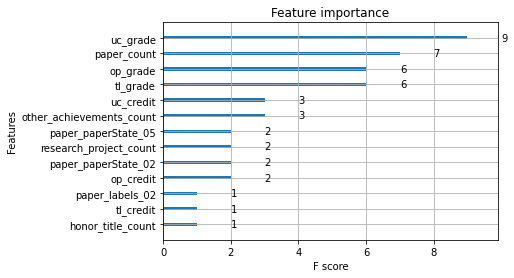

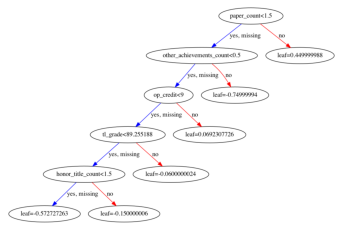

In [19]:
classifier = xgb.XGBClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree']
                            )

classifier.fit(train_x, train_y)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = train_x, y = train_y, cv = 10)
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

CrossValSTD = accuracies.std()

# Predicting the Test set results
y_pred = classifier.predict(test_x)
y_pred = pd.DataFrame(y_pred)

print("accuracy: " + str(accuracy_score(y_pred, test_y)))
xgb.plot_importance(classifier)
xgb.plot_tree(classifier)

In [25]:
classifier.get_booster().save_model("2-class_accuracy=0.615_63_features.xgb")

### 上面是一种

In [20]:
data = df_all.copy()

In [31]:
train_x, test_x, train_y, test_y = train_test_split(data, df_label, test_size=0.2, random_state=2021)

In [32]:
dtrain = xgb.DMatrix(data=train_x, label=train_y, missing=-999.0)
dtest = xgb.DMatrix(data=test_x, label=test_y, missing=-999.0)

In [33]:
from numpy.random import RandomState

trials = hyperopt.Trials()

best = fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=RandomState(123)
)

print("\n展示hyperopt获取的最佳结果，但是要注意的是我们对hyperopt最初的取值范围做过一次转换")
print(best)

[0]	train-mlogloss:0.637918	test-mlogloss:0.656532     

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.

[1]	train-mlogloss:0.599691	test-mlogloss:0.629219     

[2]	train-mlogloss:0.57179	test-mlogloss:0.606661      

[3]	train-mlogloss:0.545526	test-mlogloss:0.587633     

[4]	train-mlogloss:0.518717	test-mlogloss:0.569142     

[5]	train-mlogloss:0.496347	test-mlogloss:0.552073     

[6]	train-mlogloss:0.474744	test-mlogloss:0.53431      

[7]	train-mlogloss:0.45778	test-mlogloss:0.5252        

[8]	train-mlogloss:0.440823	test-mlogloss:0.520905     

[9]	train-mlogloss:0.428736	test-mlogloss:0.519183     

[10]	train-mlogloss:0.41559	test-mlogloss:0.519335     

[11]	train-mlogloss:0.4017	test-mlogloss:0.517028      

[12]	train-mlogloss:0.393498	test-mlogloss:0.516443    

[13]	train-mlogloss:0.385986	test-mlogloss:0.517653    

[14]	train-mlogloss:0.378014	test-mlogloss:0.5165 

[0]	train-mlogloss:0.683297	test-mlogloss:0.689225                      

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.             

[1]	train-mlogloss:0.673824	test-mlogloss:0.680795                      

[2]	train-mlogloss:0.664453	test-mlogloss:0.67267                       

[3]	train-mlogloss:0.656189	test-mlogloss:0.666864                      

[4]	train-mlogloss:0.648334	test-mlogloss:0.661672                      

[5]	train-mlogloss:0.640744	test-mlogloss:0.656808                      

[6]	train-mlogloss:0.633995	test-mlogloss:0.653345                      

[7]	train-mlogloss:0.627674	test-mlogloss:0.64885                       

[8]	train-mlogloss:0.622249	test-mlogloss:0.645012                      

[9]	train-mlogloss:0.61623	test-mlogloss:0.642367                       

[10]	train-mlogloss:0.61168	test-mlogloss:0.64058                       

[11]	train-mlogloss:0

[5]	train-mlogloss:0.27143	test-mlogloss:0.539049                       

[6]	train-mlogloss:0.255998	test-mlogloss:0.539591                      

[7]	train-mlogloss:0.242209	test-mlogloss:0.536336                      

[8]	train-mlogloss:0.2285	test-mlogloss:0.5358                          

[9]	train-mlogloss:0.21753	test-mlogloss:0.529968                       

[10]	train-mlogloss:0.214709	test-mlogloss:0.530967                     

[11]	train-mlogloss:0.21362	test-mlogloss:0.539005                      

[12]	train-mlogloss:0.210495	test-mlogloss:0.538554                     

[13]	train-mlogloss:0.210441	test-mlogloss:0.539021                     

[14]	train-mlogloss:0.208792	test-mlogloss:0.535619                     

Stopping. Best iteration:                                               
[9]	train-mlogloss:0.21753+0.0184097	test-mlogloss:0.529968+0.105823


[0]	train-mlogloss:0.673909	test-mlogloss:0.687002                      

Multiple eval metrics have been passed: 't

[26]	train-mlogloss:0.608014	test-mlogloss:0.625339                      

[27]	train-mlogloss:0.607461	test-mlogloss:0.625201                      

[28]	train-mlogloss:0.607014	test-mlogloss:0.624294                      

[29]	train-mlogloss:0.606291	test-mlogloss:0.624601                      

[0]	train-mlogloss:0.63824	test-mlogloss:0.665161                        

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.              

[1]	train-mlogloss:0.600428	test-mlogloss:0.636571                       

[2]	train-mlogloss:0.567448	test-mlogloss:0.6195                         

[3]	train-mlogloss:0.542381	test-mlogloss:0.609668                       

[4]	train-mlogloss:0.521869	test-mlogloss:0.603045                       

[5]	train-mlogloss:0.500063	test-mlogloss:0.592186                       

[6]	train-mlogloss:0.480478	test-mlogloss:0.578957                       

[7]	train

Will train until test-mlogloss hasn't improved in 5 rounds.              

[1]	train-mlogloss:0.611095	test-mlogloss:0.618359                       

[2]	train-mlogloss:0.594674	test-mlogloss:0.617174                       

[3]	train-mlogloss:0.590122	test-mlogloss:0.611344                       

[4]	train-mlogloss:0.58789	test-mlogloss:0.604153                        

[5]	train-mlogloss:0.583651	test-mlogloss:0.601047                       

[6]	train-mlogloss:0.584936	test-mlogloss:0.595598                       

[7]	train-mlogloss:0.583905	test-mlogloss:0.597378                       

[8]	train-mlogloss:0.583464	test-mlogloss:0.609193                       

[9]	train-mlogloss:0.577146	test-mlogloss:0.610881                       

[10]	train-mlogloss:0.574916	test-mlogloss:0.604833                      

[11]	train-mlogloss:0.575553	test-mlogloss:0.607696                      

Stopping. Best iteration:                                                
[6]	train-mlogloss:0.58493

[19]	train-mlogloss:0.347936	test-mlogloss:0.502779                      

[20]	train-mlogloss:0.34369	test-mlogloss:0.4952                         

[21]	train-mlogloss:0.339543	test-mlogloss:0.496309                      

[22]	train-mlogloss:0.336028	test-mlogloss:0.493402                      

[23]	train-mlogloss:0.333918	test-mlogloss:0.493591                      

[24]	train-mlogloss:0.327862	test-mlogloss:0.496042                      

[25]	train-mlogloss:0.325145	test-mlogloss:0.497442                      

[26]	train-mlogloss:0.323332	test-mlogloss:0.499224                      

[27]	train-mlogloss:0.320436	test-mlogloss:0.49875                       

Stopping. Best iteration:                                                
[22]	train-mlogloss:0.336028+0.0163001	test-mlogloss:0.493402+0.0440049


[0]	train-mlogloss:0.628481	test-mlogloss:0.662449                       

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train 

[6]	train-mlogloss:0.302644	test-mlogloss:0.518517                       

[7]	train-mlogloss:0.291196	test-mlogloss:0.521831                       

[8]	train-mlogloss:0.279942	test-mlogloss:0.526444                       

[9]	train-mlogloss:0.266995	test-mlogloss:0.514019                       

[10]	train-mlogloss:0.256584	test-mlogloss:0.509719                      

[11]	train-mlogloss:0.253392	test-mlogloss:0.51431                       

[12]	train-mlogloss:0.249459	test-mlogloss:0.511575                      

[13]	train-mlogloss:0.244375	test-mlogloss:0.518255                      

[14]	train-mlogloss:0.241869	test-mlogloss:0.516775                      

[15]	train-mlogloss:0.241845	test-mlogloss:0.516892                      

Stopping. Best iteration:                                                
[10]	train-mlogloss:0.256584+0.0164768	test-mlogloss:0.509719+0.0941302


[0]	train-mlogloss:0.631428	test-mlogloss:0.653848                       

Multiple eval metrics have 

[5]	train-mlogloss:0.38115	test-mlogloss:0.55359                         

[6]	train-mlogloss:0.362918	test-mlogloss:0.543516                       

[7]	train-mlogloss:0.346654	test-mlogloss:0.546311                       

[8]	train-mlogloss:0.32254	test-mlogloss:0.54202                         

[9]	train-mlogloss:0.310998	test-mlogloss:0.544533                       

[10]	train-mlogloss:0.298729	test-mlogloss:0.538581                      

[11]	train-mlogloss:0.285048	test-mlogloss:0.552342                      

[12]	train-mlogloss:0.277729	test-mlogloss:0.550638                      

[13]	train-mlogloss:0.267588	test-mlogloss:0.550518                      

[14]	train-mlogloss:0.264293	test-mlogloss:0.557961                      

[15]	train-mlogloss:0.256107	test-mlogloss:0.562314                      

Stopping. Best iteration:                                                
[10]	train-mlogloss:0.298729+0.0186563	test-mlogloss:0.538581+0.0707033


[0]	train-mlogloss:0.624337

Will train until test-mlogloss hasn't improved in 5 rounds.              

[1]	train-mlogloss:0.680511	test-mlogloss:0.684525                       

[2]	train-mlogloss:0.675102	test-mlogloss:0.680602                       

[3]	train-mlogloss:0.669999	test-mlogloss:0.676343                       

[4]	train-mlogloss:0.664769	test-mlogloss:0.67328                        

[5]	train-mlogloss:0.659582	test-mlogloss:0.669542                       

[6]	train-mlogloss:0.654124	test-mlogloss:0.665628                       

[7]	train-mlogloss:0.648703	test-mlogloss:0.662034                       

[8]	train-mlogloss:0.643048	test-mlogloss:0.659049                       

[9]	train-mlogloss:0.638073	test-mlogloss:0.656099                       

[10]	train-mlogloss:0.63347	test-mlogloss:0.653651                       

[11]	train-mlogloss:0.628632	test-mlogloss:0.651495                      

[12]	train-mlogloss:0.624277	test-mlogloss:0.64832                       

[13]	train-mlogloss:0.619

[9]	train-mlogloss:0.546554	test-mlogloss:0.58602                        

[10]	train-mlogloss:0.541731	test-mlogloss:0.581671                      

[11]	train-mlogloss:0.534453	test-mlogloss:0.589293                      

[12]	train-mlogloss:0.53153	test-mlogloss:0.590457                       

[13]	train-mlogloss:0.528194	test-mlogloss:0.592007                      

[14]	train-mlogloss:0.522999	test-mlogloss:0.586773                      

[15]	train-mlogloss:0.519907	test-mlogloss:0.589775                      

Stopping. Best iteration:                                                
[10]	train-mlogloss:0.541731+0.00835696	test-mlogloss:0.581671+0.0545681


[0]	train-mlogloss:0.689443	test-mlogloss:0.691297                       

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.              

[1]	train-mlogloss:0.68649	test-mlogloss:0.688785                        

[2]	train-

[1]	train-mlogloss:0.591962	test-mlogloss:0.633526                       

[2]	train-mlogloss:0.55889	test-mlogloss:0.617675                        

[3]	train-mlogloss:0.533243	test-mlogloss:0.609578                       

[4]	train-mlogloss:0.508688	test-mlogloss:0.588993                       

[5]	train-mlogloss:0.484535	test-mlogloss:0.584084                       

[6]	train-mlogloss:0.464023	test-mlogloss:0.568251                       

[7]	train-mlogloss:0.452271	test-mlogloss:0.573223                       

[8]	train-mlogloss:0.438987	test-mlogloss:0.577599                       

[9]	train-mlogloss:0.416818	test-mlogloss:0.563369                       

[10]	train-mlogloss:0.408306	test-mlogloss:0.563421                      

[11]	train-mlogloss:0.399556	test-mlogloss:0.573822                      

[12]	train-mlogloss:0.38865	test-mlogloss:0.569963                       

[13]	train-mlogloss:0.382115	test-mlogloss:0.580107                      

[14]	train-mlogloss:0.377

Stopping. Best iteration:                                                
[15]	train-mlogloss:0.385944+0.0198078	test-mlogloss:0.588596+0.119048


[0]	train-mlogloss:0.567893	test-mlogloss:0.634845                       

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.              

[1]	train-mlogloss:0.492334	test-mlogloss:0.606666                       

[2]	train-mlogloss:0.438242	test-mlogloss:0.587204                       

[3]	train-mlogloss:0.387668	test-mlogloss:0.568708                       

[4]	train-mlogloss:0.346196	test-mlogloss:0.54504                        

[5]	train-mlogloss:0.314736	test-mlogloss:0.523725                       

[6]	train-mlogloss:0.289236	test-mlogloss:0.529016                       

[7]	train-mlogloss:0.270556	test-mlogloss:0.524707                       

[8]	train-mlogloss:0.259522	test-mlogloss:0.525771                       

[9]	train-ml

[22]	train-mlogloss:0.3779	test-mlogloss:0.550277                        

[23]	train-mlogloss:0.374026	test-mlogloss:0.555042                      

[24]	train-mlogloss:0.368325	test-mlogloss:0.549834                      

[25]	train-mlogloss:0.363284	test-mlogloss:0.550349                      

[26]	train-mlogloss:0.357087	test-mlogloss:0.550634                      

[27]	train-mlogloss:0.353541	test-mlogloss:0.553343                      

[28]	train-mlogloss:0.348984	test-mlogloss:0.554683                      

[29]	train-mlogloss:0.346051	test-mlogloss:0.555572                      

Stopping. Best iteration:                                                
[24]	train-mlogloss:0.368325+0.0123593	test-mlogloss:0.549834+0.0313894


[0]	train-mlogloss:0.586486	test-mlogloss:0.640082                       

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.              

[1]	train-m

[12]	train-mlogloss:0.23269	test-mlogloss:0.558061                       

Stopping. Best iteration:                                                
[7]	train-mlogloss:0.288271+0.0195402	test-mlogloss:0.534746+0.0799339


[0]	train-mlogloss:0.638514	test-mlogloss:0.660624                       

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.              

[1]	train-mlogloss:0.608161	test-mlogloss:0.638903                       

[2]	train-mlogloss:0.583583	test-mlogloss:0.614747                       

[3]	train-mlogloss:0.57426	test-mlogloss:0.603626                        

[4]	train-mlogloss:0.561112	test-mlogloss:0.593396                       

[5]	train-mlogloss:0.548599	test-mlogloss:0.596512                       

[6]	train-mlogloss:0.54286	test-mlogloss:0.589391                        

[7]	train-mlogloss:0.537051	test-mlogloss:0.592524                       

[8]	train-ml

[23]	train-mlogloss:0.558705	test-mlogloss:0.612345                      

[24]	train-mlogloss:0.556967	test-mlogloss:0.608876                      

[25]	train-mlogloss:0.556358	test-mlogloss:0.607997                      

[26]	train-mlogloss:0.554785	test-mlogloss:0.608516                      

[27]	train-mlogloss:0.553813	test-mlogloss:0.608206                      

[28]	train-mlogloss:0.552335	test-mlogloss:0.608926                      

[29]	train-mlogloss:0.550742	test-mlogloss:0.611005                      

[0]	train-mlogloss:0.635947	test-mlogloss:0.663841                       

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.              

[1]	train-mlogloss:0.585422	test-mlogloss:0.632107                       

[2]	train-mlogloss:0.55801	test-mlogloss:0.602273                        

[3]	train-mlogloss:0.526481	test-mlogloss:0.576113                       

[4]	train

[13]	train-mlogloss:0.314961	test-mlogloss:0.550634                      

[14]	train-mlogloss:0.309912	test-mlogloss:0.547558                      

[15]	train-mlogloss:0.305946	test-mlogloss:0.551758                      

Stopping. Best iteration:                                                
[10]	train-mlogloss:0.339133+0.0254841	test-mlogloss:0.524406+0.0461584


[0]	train-mlogloss:0.667077	test-mlogloss:0.682326                       

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.              

[1]	train-mlogloss:0.637599	test-mlogloss:0.659566                       

[2]	train-mlogloss:0.615159	test-mlogloss:0.632797                       

[3]	train-mlogloss:0.596592	test-mlogloss:0.626088                       

[4]	train-mlogloss:0.582998	test-mlogloss:0.606932                       

[5]	train-mlogloss:0.572212	test-mlogloss:0.603318                       

[6]	train-m

[23]	train-mlogloss:0.325489	test-mlogloss:0.505738                      

[24]	train-mlogloss:0.321471	test-mlogloss:0.502579                      

[25]	train-mlogloss:0.318579	test-mlogloss:0.504376                      

[26]	train-mlogloss:0.313563	test-mlogloss:0.50484                       

[27]	train-mlogloss:0.309629	test-mlogloss:0.506189                      

[28]	train-mlogloss:0.304806	test-mlogloss:0.502479                      

[29]	train-mlogloss:0.30101	test-mlogloss:0.497954                       

[0]	train-mlogloss:0.642364	test-mlogloss:0.663435                       

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.              

[1]	train-mlogloss:0.602241	test-mlogloss:0.64111                        

[2]	train-mlogloss:0.567912	test-mlogloss:0.625271                       

[3]	train-mlogloss:0.541688	test-mlogloss:0.604197                       

[4]	train

[17]	train-mlogloss:0.417722	test-mlogloss:0.553005                      

[18]	train-mlogloss:0.414118	test-mlogloss:0.551644                      

[19]	train-mlogloss:0.405915	test-mlogloss:0.54739                       

[20]	train-mlogloss:0.401342	test-mlogloss:0.543706                      

[21]	train-mlogloss:0.396705	test-mlogloss:0.543256                      

[22]	train-mlogloss:0.391027	test-mlogloss:0.538325                      

[23]	train-mlogloss:0.387727	test-mlogloss:0.538827                      

[24]	train-mlogloss:0.382863	test-mlogloss:0.534422                      

[25]	train-mlogloss:0.38008	test-mlogloss:0.533848                       

[26]	train-mlogloss:0.37375	test-mlogloss:0.537155                       

[27]	train-mlogloss:0.370655	test-mlogloss:0.536716                      

[28]	train-mlogloss:0.366633	test-mlogloss:0.53534                       

[29]	train-mlogloss:0.361119	test-mlogloss:0.536381                      

[0]	train-mlogloss:0.6545

[5]	train-mlogloss:0.382146	test-mlogloss:0.546371                       

[6]	train-mlogloss:0.355496	test-mlogloss:0.53273                        

[7]	train-mlogloss:0.339897	test-mlogloss:0.529196                       

[8]	train-mlogloss:0.322893	test-mlogloss:0.527673                       

[9]	train-mlogloss:0.312381	test-mlogloss:0.523438                       

[10]	train-mlogloss:0.301694	test-mlogloss:0.519664                      

[11]	train-mlogloss:0.295795	test-mlogloss:0.525222                      

[12]	train-mlogloss:0.289556	test-mlogloss:0.525684                      

[13]	train-mlogloss:0.282789	test-mlogloss:0.522827                      

[14]	train-mlogloss:0.280613	test-mlogloss:0.523328                      

[15]	train-mlogloss:0.276071	test-mlogloss:0.515576                      

[16]	train-mlogloss:0.26812	test-mlogloss:0.511779                       

[17]	train-mlogloss:0.264839	test-mlogloss:0.51119                       

[18]	train-mlogloss:0.262

[19]	train-mlogloss:0.420423	test-mlogloss:0.565879                      

[20]	train-mlogloss:0.418618	test-mlogloss:0.560295                      

[21]	train-mlogloss:0.415795	test-mlogloss:0.564953                      

[22]	train-mlogloss:0.414366	test-mlogloss:0.564866                      

[23]	train-mlogloss:0.413145	test-mlogloss:0.570009                      

[24]	train-mlogloss:0.410953	test-mlogloss:0.562523                      

[25]	train-mlogloss:0.408155	test-mlogloss:0.5586                        

[26]	train-mlogloss:0.404598	test-mlogloss:0.558803                      

[27]	train-mlogloss:0.402614	test-mlogloss:0.562644                      

[28]	train-mlogloss:0.399551	test-mlogloss:0.563531                      

[29]	train-mlogloss:0.396799	test-mlogloss:0.568725                      

[0]	train-mlogloss:0.638285	test-mlogloss:0.659119                       

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will trai

[15]	train-mlogloss:0.464007	test-mlogloss:0.595192                      

Stopping. Best iteration:                                                
[10]	train-mlogloss:0.500227+0.0114295	test-mlogloss:0.584972+0.0395705


[0]	train-mlogloss:0.651084	test-mlogloss:0.670184                       

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.


Will train until test-mlogloss hasn't improved in 5 rounds.              

[1]	train-mlogloss:0.605679	test-mlogloss:0.644399                       

[2]	train-mlogloss:0.575527	test-mlogloss:0.621642                       

[3]	train-mlogloss:0.550233	test-mlogloss:0.611267                       

[4]	train-mlogloss:0.520992	test-mlogloss:0.586838                       

[5]	train-mlogloss:0.496775	test-mlogloss:0.579111                       

[6]	train-mlogloss:0.48121	test-mlogloss:0.573084                        

[7]	train-mlogloss:0.470627	test-mlogloss:0.576716                       

[8]	train-m

[1]	train-mlogloss:0.614566	test-mlogloss:0.635884                       

[2]	train-mlogloss:0.589353	test-mlogloss:0.637093                       

[3]	train-mlogloss:0.581341	test-mlogloss:0.642966                       

[4]	train-mlogloss:0.568035	test-mlogloss:0.639                          

[5]	train-mlogloss:0.559196	test-mlogloss:0.633704                       

[6]	train-mlogloss:0.563503	test-mlogloss:0.635502                       

[7]	train-mlogloss:0.544428	test-mlogloss:0.632463                       

[8]	train-mlogloss:0.541093	test-mlogloss:0.643946                       

[9]	train-mlogloss:0.529047	test-mlogloss:0.625399                       

[10]	train-mlogloss:0.522485	test-mlogloss:0.597657                      

[11]	train-mlogloss:0.516417	test-mlogloss:0.59788                       

[12]	train-mlogloss:0.516291	test-mlogloss:0.594649                      

[13]	train-mlogloss:0.511906	test-mlogloss:0.590516                      

[14]	train-mlogloss:0.509

Final CrossValMean:  0.7900000000000001
accuracy: 0.9615384615384616


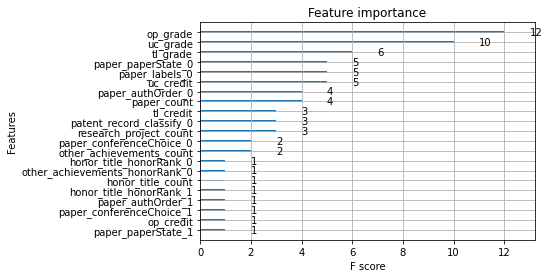

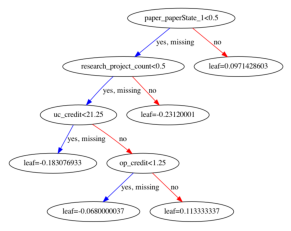

In [34]:
classifier = xgb.XGBClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree']
                            )

classifier.fit(train_x, train_y)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = train_x, y = train_y, cv = 10)
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

CrossValSTD = accuracies.std()

# Predicting the Test set results
y_pred = classifier.predict(test_x)
y_pred = pd.DataFrame(y_pred)

print("accuracy: " + str(accuracy_score(y_pred, test_y)))
xgb.plot_importance(classifier)
xgb.plot_tree(classifier)

In [28]:
nmd还是不做one-hot好一点

NameError: name 'nmd还是不做one' is not defined

In [35]:
y_pred = classifier.predict(train_x)
y_pred = pd.DataFrame(y_pred)

print("accuracy: " + str(accuracy_score(y_pred, train_y)))

accuracy: 0.87


In [30]:
classifier.get_booster().save_model("2-class_accuracy=0.88_63_features.xgb")